In [1]:
from libtiff import TIFF
import os
import matplotlib.pyplot as plt
import shapefile as shp
import numpy as np
import pyproj
import rasterio
import math
from PIL import Image
import csv

# Utilities functions

In [31]:
def extract_coordinates(path_to_shp, x_upper_bound,x_lower_bound, y_upper_bound,y_lower_bound, output_shape):
    sf = shp.Reader(path_to_shp)
    x = []
    y = []
    for shape in sf.shapeRecords():
        x.append([i[0] for i in shape.shape.points[:]][0])
        y.append([i[1] for i in shape.shape.points[:]][0])

    # computing diplacement from bound
    xnorm = (np.array(x) - x_lower_bound) / (x_upper_bound - x_lower_bound)
    ynorm = (np.array(y) - y_lower_bound) / (y_upper_bound - y_lower_bound) 
    
    # scale to number of pixels
    xnorm *= output_shape[0]
    ynorm *= output_shape[1]

    # account for inverted index
    ynorm = np.abs(ynorm-output_shape[1])

    return np.round(xnorm), np.round(ynorm)

def class_matrix(classes, inputsize):
    '''
    Create matrix of weed types and convert labels to numeric
    '''
    # initialize matrix
    matrix = np.zeros((inputsize,inputsize))
    for i in range(inputsize):
        if i in classes[:,0]:
            loc = int(np.where(classes[:,0] == i)[0][0])
            j = classes[:,1][loc]
            class_index = classes[:,2][loc]
            matrix[int(i)][int(j)] = class_index
    
    return matrix

def splitdata(data, classes, splitsize):

    def multiples(m, count):
        val = [i*m for i in range(int(count))]
        return val

    assert classes.shape == data.shape[:2]

    images = []
    labels = []
    #compute batch by batch
    dims = multiples(splitsize, np.round(data.shape[0]/splitsize)+1)
    for i, d1 in enumerate(dims):
        for j, d2 in enumerate(dims):
            try:
                images.append(data[d1:dims[i+1], d2:dims[j+1]])
                labels.append(onehot_conversion(np.unique(classes[d1:dims[i+1], d2:dims[j+1]])))
                
            except IndexError:
                continue
                


    return images, labels

def onehot_conversion(label):
    new_label = np.zeros(4)
    for lb in label:
        if lb == 0 and len(label) == 1:
            new_label[int(lb)] = 1
            break
        elif lb != 0:
            new_label[int(lb)] = 1
    return new_label

    

# Displaying/Processing image 1

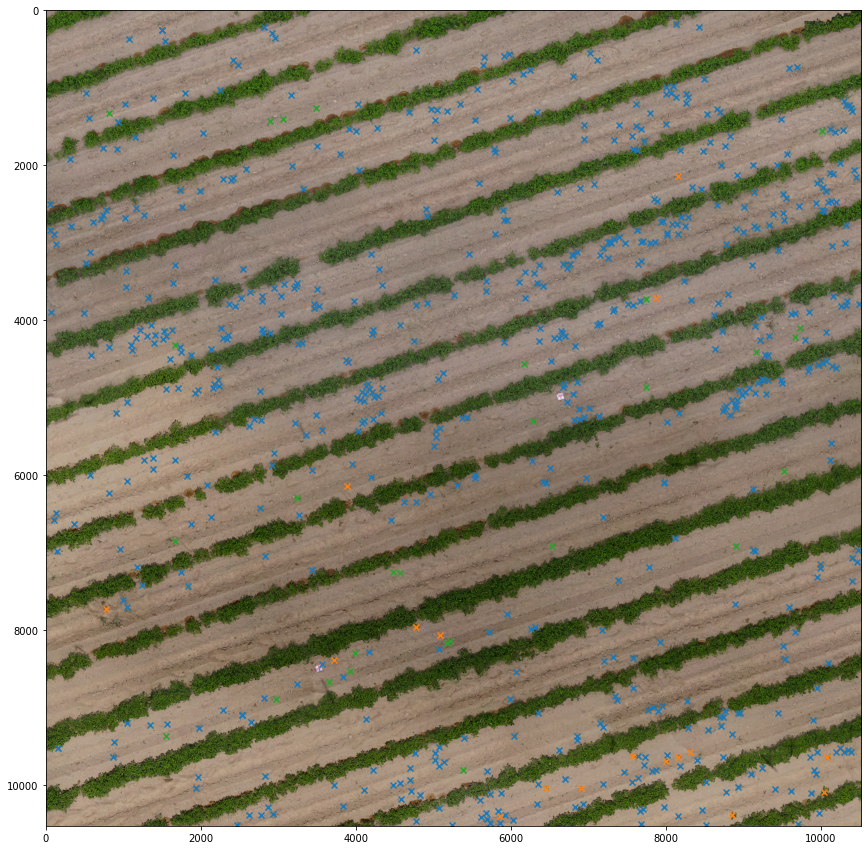


Summary of labels:
Total labelled weeds : 663
Cyperus count: 618
Portulaca count: 17
Solanum count: 28



In [32]:
# extract labels in tif file
raw = TIFF.open('data/P1_Dron-image/Santa-Amalia_Field1_Zona-1.tif')
# get coordinates of image
coords = rasterio.open('data/P1_Dron-image/Santa-Amalia_Field1_Zona-1.tif')
#yaxis bounds
ybound_low = coords.bounds[1]
ybound_high = coords.bounds[3]

#xaxis bounds
xbound_low = coords.bounds[0]
xbound_high = coords.bounds[2]

# convert to tiff
tif = raw.read_image()

# extract coordinate points
cyperus_x,cyperus_y = extract_coordinates('data/P1_weed_Cyperus/Cyperus_P1.shp',xbound_high,xbound_low,ybound_high, ybound_low,  tif.shape)
portulaca_x,portulaca_y = extract_coordinates('data/P1_weed_Portulaca/Portulaca_P1.shp',xbound_high,xbound_low,ybound_high, ybound_low,  tif.shape)
solanum_x,solanum_y = extract_coordinates('data/P1_weed_Solanum/Solanum_P1.shp',xbound_high,xbound_low,ybound_high, ybound_low,  tif.shape)


plt.figure(figsize = (15,15))
im = plt.imshow(tif)
plt.scatter(cyperus_x,cyperus_y, marker = 'x', label = 'Cyperus')
plt.scatter(portulaca_x,portulaca_y, marker = 'x', label = 'Portulaca')
plt.scatter(solanum_x,solanum_y, marker = 'x', label = 'Solanum')

plt.legend
plt.show()

print("""
Summary of labels:
Total labelled weeds : {}
Cyperus count: {}
Portulaca count: {}
Solanum count: {}
""".format((len(cyperus_x)+ len(portulaca_x)+ len(solanum_x)),len(cyperus_x), len(portulaca_x), len(solanum_x)))

In [33]:
# labelling classes
cyperus_class = np.stack([cyperus_x, cyperus_y, np.ones(len(cyperus_x))], axis =1)
portulaca_class = np.stack([portulaca_x, portulaca_y, np.ones(len(portulaca_x))*2], axis =1)
solanum_class = np.stack([solanum_x, solanum_y, np.ones(len(solanum_x))*3], axis =1)

# concatenate all classes
classes = np.concatenate([cyperus_class, portulaca_class, solanum_class])

# build out class matrix
class_mat = class_matrix(classes, inputsize = tif.shape[0])

# split mosaic image into seperate sprayable patches
images1, labels1 = splitdata(tif, class_mat, splitsize =256)

# Displaying/Processing image 2

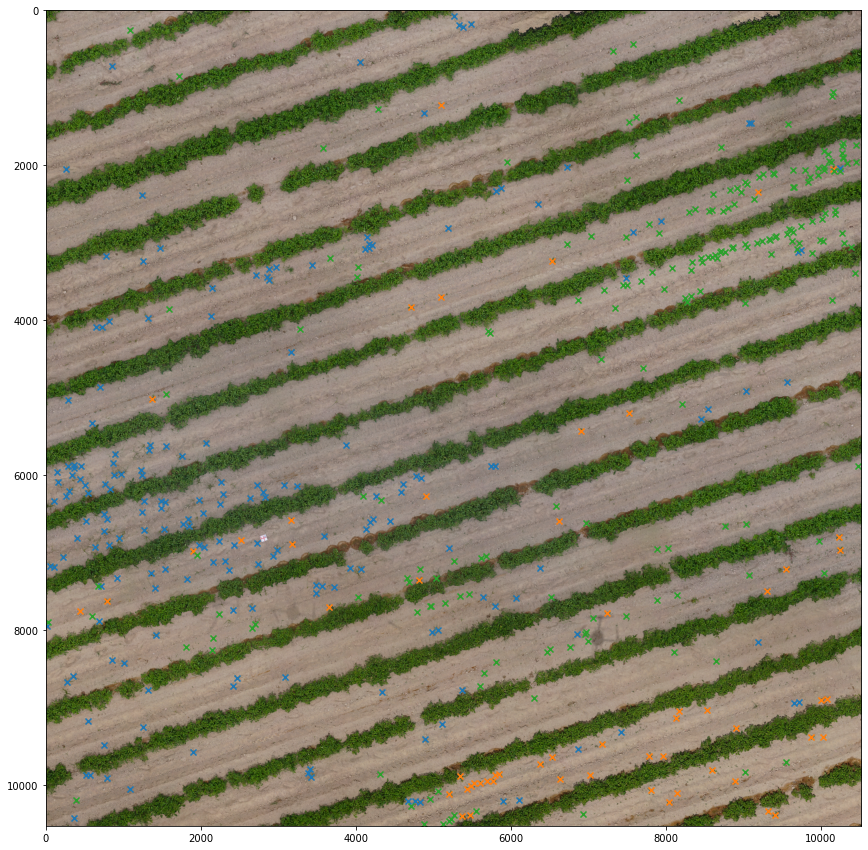


Summary of labels:
Total labelled weeds : 447 
Cyperus count: 191
Portulaca count: 58
Solanum count: 198 



In [34]:
# extract labels in tif file
raw = TIFF.open('data/P2_Dron-image/Santa-Amalia_Field1_Zona-2.tif')
# get coordinates of image
coords = rasterio.open('data/P2_Dron-image/Santa-Amalia_Field1_Zona-2.tif')
#yaxis bounds
ybound_low = coords.bounds[1]
ybound_high = coords.bounds[3]

#xaxis bounds
xbound_low = coords.bounds[0]
xbound_high = coords.bounds[2]

# convert to tiff
tif = raw.read_image()
# converting to uint8
tif = tif.astype(np.uint8)

# extract coordinate points
cyperus_x,cyperus_y = extract_coordinates('data/P2_weed_Cyperus/Cyperus.shp',xbound_high,xbound_low,ybound_high, ybound_low,  tif.shape)
portulaca_x,portulaca_y = extract_coordinates('data/P2_weed_Portulaca/Portulaca.shp',xbound_high,xbound_low,ybound_high, ybound_low,  tif.shape)
solanum_x,solanum_y = extract_coordinates('data/P2_weed_Solanum/Solanum.shp',xbound_high,xbound_low,ybound_high, ybound_low,  tif.shape)


plt.figure(figsize = (15,15))
im = plt.imshow(tif)
plt.scatter(cyperus_x,cyperus_y, marker = 'x', label = 'Cyperus')
plt.scatter(portulaca_x,portulaca_y, marker = 'x', label = 'Portulaca')
plt.scatter(solanum_x,solanum_y, marker = 'x', label = 'Solanum')
#plt.xlim([3000, 2000])
#plt.ylim([5000, 7000])
plt.legend
plt.show()

print("""
Summary of labels:
Total labelled weeds : {} 
Cyperus count: {}
Portulaca count: {}
Solanum count: {} 
""".format((len(cyperus_x)+ len(portulaca_x)+ len(solanum_x)),len(cyperus_x), len(portulaca_x), len(solanum_x)))

In [35]:
# labelling classes
cyperus_class = np.stack([cyperus_x, cyperus_y, np.ones(len(cyperus_x))], axis =1)
portulaca_class = np.stack([portulaca_x, portulaca_y, np.ones(len(portulaca_x))*2], axis =1)
solanum_class = np.stack([solanum_x, solanum_y, np.ones(len(solanum_x))*2], axis =1)

# concatenate all classes
classes = np.concatenate([cyperus_class, portulaca_class, solanum_class])

# build out class matrix
class_mat = class_matrix(classes, inputsize = tif.shape[0])

# split mosaic image into seperate sprayable patches
images2, labels2 = splitdata(tif, class_mat, splitsize =256)

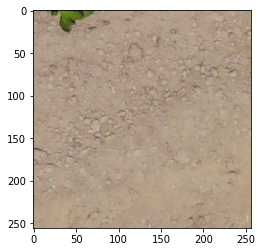

In [36]:
images = images1+images2
labels = labels1+labels2

plt.imshow(images[1680])
plt.show()


### Saving cropped images

In [38]:

try:
    # Create  Directory  MyDirectory 
    os.mkdir('image_slides')
    #print if directory created successfully...
    print("Directory " , 'image_slides' ,  " Created ") 
except FileExistsError:
    ##print if directory already exists...
    print("Directory " , 'image_slides' ,  " already exists...")        


for idx, image in enumerate(images):
    im = Image.fromarray(image)
    im.save("image_slides/image{}.png".format(idx+1))


Directory  image_slides  Created 


### Saving cropped image labels - One hot encoding

In [19]:
# open the file in the write mode
f = open('image_slides_labels.csv', 'w')

# create the csv writer
writer = csv.writer(f)
for label in labels:
    # write a row to the csv file
    writer.writerow(label)

# close the file
f.close()

In [12]:
print('Examining the depth of the images...')
summed_labels = np.sum(labels, axis=1)
# checking how many images have no weeds
print('Total number of images: ',len(labels))
print('Total number of images that do not contain any weeds : ',len(labels)-np.count_nonzero(summed_labels))
print('Total number of images that contain weeds : ',np.count_nonzero(summed_labels))
print('Number of images with 1 different weed species : ',len(np.where(np.array(summed_labels) == 1)[0]))
print('Number of images with 2 different weed species : ',len(np.where(np.array(summed_labels) == 2)[0]))
print('Number of images with 3 different weed species : ',len(np.where(np.array(summed_labels) == 3)[0]))


Examining the depth of the images...
Total number of images:  3362
Total number of images that do not contain any weeds :  0
Total number of images that contain weeds :  3362
Number of images with 1 different weed species :  3337
Number of images with 2 different weed species :  25
Number of images with 3 different weed species :  0
